In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import pybtex.database
import sys
import seaborn as sns

os.chdir("..")

from latex.bubble_plot import Config, Facets, build_and_save_plots
from typing import Sequence, Dict, Tuple

sns.set_style("darkgrid")

In [2]:
os.makedirs("./images/", exist_ok=True)
path = "/home/greca/Downloads/resultados_triagem1.xls"
excel = pd.read_excel(path)
excel.head()

,bibtex_key,title,author,journal,year,source,pages,volume,abstract,document_type,...,issn,language,note,selection_criteria,created_at,updated_at,created_by,updated_by,status,comments
0,NaN,Analysis of Constant-Q Filterbank Based Repres...,"Singh, Premjeet and Waldekar, Shefali and Sahi...",Digit. Signal Process.,2022,ACM Digital Library,NaN,130,None,NaN,...,1051-2004,NaN,NaN,Estudos duplicados,45018.887616,45018.889977,rafaelgreca,rafaelgreca,Rejected,NaN
1,NaN,Analysis of Sub-Integral Functions in the Aggr...,"Karczmarek, Pawe\l{} and Powroznik, Pawel and ...",NaN,2022,ACM Digital Library,1–8,NaN,Speech emotion recognition is a complicated an...,NaN,...,NaN,NaN,NaN,Estudos duplicados,45018.887616,45018.889421,rafaelgreca,rafaelgreca,Rejected,NaN
2,NaN,Feature Extraction Algorithms to Improve the S...,"Koduru, Anusha and Valiveti, Hima Bindu and Bu...",Int. J. Speech Technol.,2020,ACM Digital Library,45–55,23,In this digitally growing era speech emotion r...,NaN,...,1381-2416,NaN,NaN,Estudos duplicados,45018.887616,45018.888750,rafaelgreca,rafaelgreca,Rejected,NaN
3,NaN,Innovative Variational AutoEncoder for an End-...,"Alawad, Mohamad A. and Hamdan, Mutasem Q. and ...",IEEE Access,2022,IEEE Digital Library,1-1,NaN,"Powered by deep learning (DL), autoencoders (A...",NaN,...,2169-3536,NaN,NaN,Estudos duplicados,45018.866262,45018.870185,rafaelgreca,rafaelgreca,Rejected,NaN
4,NaN,Performance of DWT-ANN based signal detector/e...,"Rajbhandari, S. and Ghassemlooy, Z. and Angelo...",NaN,2008,IEEE Digital Library,106-109,NaN,Artificial neural network (ANN) finds its appl...,NaN,...,NaN,NaN,NaN,Estudos duplicados,45018.866262,45018.869063,rafaelgreca,rafaelgreca,Rejected,NaN


In [3]:
temp = excel.copy()
temp = temp["status"].value_counts().reset_index()
temp = temp.replace(
    {
        "Rejected": "Rejeitados",
        "Accepted": "Aceitos",
    }
)
temp.columns = ["status", "total"]

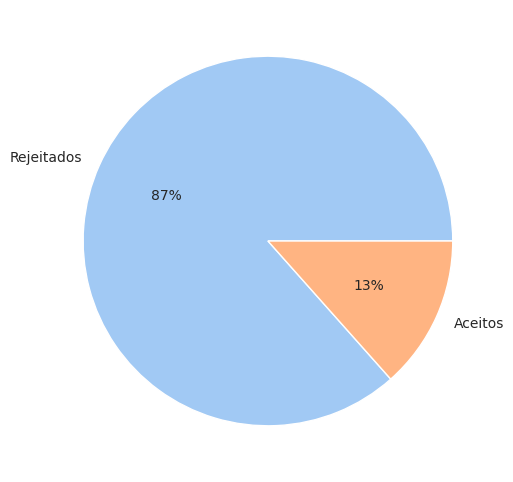

In [4]:
plt.figure(figsize=(8, 6))

colors = sns.color_palette("pastel")[0:2]

ax = plt.pie(
    temp["total"].values.tolist(),
    labels=temp["status"].values.tolist(),
    autopct="%.0f%%",
    colors=colors,
)
plt.savefig("./images/triagem1.png")

In [5]:
rejecteds = excel[excel["status"] == "Rejected"].copy()
rejecteds = rejecteds.reset_index(drop=True)
rejecteds = rejecteds[
    ["title", "author", "journal", "year", "source", "selection_criteria"]
]
rejecteds_by_criteria = rejecteds.replace(
    {
        "Estudos duplicados": "Duplicados",
        "Estudos que não são sobre reconhecimento de emoções da fala": "Fora do tema de REF",
        "Estudos secundários": "Secundários",
        "Estudos antes de 2018": "Antes de 2018",
        "Estudos em qualquer idioma que não seja inglês": "Outros",
        "Livros, capítulo de livros, slides, pôsteres ou páginas na web": "Outros",
        "Estudos que não utilizam wavelets": "Outros",
    }
)
rejecteds_by_criteria = (
    rejecteds_by_criteria["selection_criteria"].value_counts().reset_index()
)
rejecteds_by_criteria.columns = ["criteria", "total"]

del rejecteds

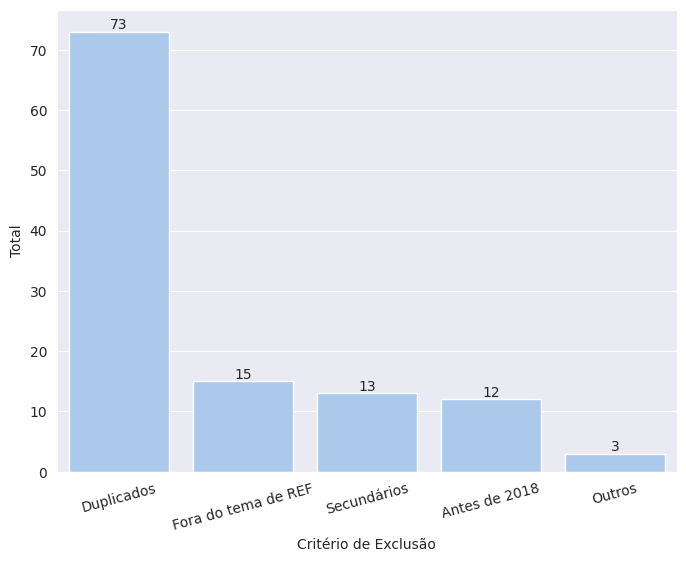

In [6]:
plt.figure(figsize=(8, 6))

ax = sns.barplot(data=rejecteds_by_criteria, x="criteria", y="total", color=colors[0])

for i in ax.containers:
    ax.bar_label(
        i,
    )

plt.xticks(rotation=15)
plt.xlabel("Critério de Exclusão")
plt.ylabel("Total")
plt.savefig("./images/triagem1_rejeitados.png")

In [7]:
from pprint import pprint


def process_input(bib_file: str, labels_cls: Sequence[str]) -> Sequence[Dict[str, str]]:
    """Extract labels and values"""
    references = []
    joined_labels_cls = ", ".join(labels_cls)
    bib_input = pybtex.database.parse_file(bib_file, bib_format="bibtex")
    for key, entry in bib_input.entries.items():
        current = {}
        for label in entry.fields["note"].split(","):
            label_cls, label_val = map(lambda s: s.strip(), label.split(":"))
            if label_cls not in labels_cls:
                print(
                    (
                        f"[!] The label class: {label_cls} in: "
                        f"{label} of entry {key} is not "
                        f"one of: {joined_labels_cls}."
                    ),
                    file=sys.stderr,
                )
                continue
            current[label_cls] = label_val
        references.append(current)
    return references


os.makedirs("./latex", exist_ok=True)

LABELS = ("FAMILY", "TYPE", "MODEL", "YEAR")
ENTRIES = process_input("./latex/references.bib", LABELS)
pprint(ENTRIES)

NBR_YEAR = len({entry["YEAR"] for entry in ENTRIES})
COLOR_MAP = sns.cubehelix_palette(rot=-0.2)[:NBR_YEAR]

CONFIG = Config(
    x_left_offset=2,
    x_right_offset=3,
    class_year="YEAR",
    field_names=["iy", "ix", "nbr", "years", "y", "x"],
    latex_template="./latex/template.tex",
    output_dir=OUTPUT_DIR,
    color_map=COLOR_MAP,
)

PLOTS_PLAN = [
    Facets(y="MODEL", x_left="TYPE", x_right="FAMILY"),
]

build_and_save_plots(ENTRIES, PLOTS_PLAN, CONFIG)

[{'FAMILY': 'Desconhecida',
  'MODEL': 'Rede de Crenças Profundas',
  'TYPE': 'TPW',
  'YEAR': '2019'},
 {'FAMILY': 'Desconhecida', 'MODEL': 'NB', 'TYPE': 'TDW', 'YEAR': '2019'},
 {'FAMILY': 'Desconhecida', 'MODEL': 'SVM', 'TYPE': 'TDW', 'YEAR': '2019'},
 {'FAMILY': 'Daubechies', 'MODEL': 'MLP', 'TYPE': 'TDW', 'YEAR': '2022'},
 {'FAMILY': 'Daubechies',
  'MODEL': 'LSTM bidirecional com atenção',
  'TYPE': 'TPW',
  'YEAR': '2021'},
 {'FAMILY': 'Morlet',
  'MODEL': 'RNC-LSTM',
  'TYPE': 'Escalograma',
  'YEAR': '2020'},
 {'FAMILY': 'Haar', 'MODEL': 'SVM', 'TYPE': 'TDW', 'YEAR': '2020'},
 {'FAMILY': 'Haar',
  'MODEL': 'Árvores de Decisão',
  'TYPE': 'TDW',
  'YEAR': '2020'},
 {'FAMILY': 'Haar',
  'MODEL': 'Linear Discriminant Analysis',
  'TYPE': 'TDW',
  'YEAR': '2020'},
 {'FAMILY': 'Daubechies', 'MODEL': 'SVM', 'TYPE': 'TDW', 'YEAR': '2018'},
 {'FAMILY': 'Daubechies', 'MODEL': 'NB', 'TYPE': 'TDW', 'YEAR': '2018'},
 {'FAMILY': 'Daubechies', 'MODEL': 'KNN', 'TYPE': 'TDW', 'YEAR': '2018'},

NameError: name 'OUTPUT_DIR' is not defined